In [1]:
library(data.table)
library(dplyr)
library(Matrix)
library(BuenColors)
library(stringr)
library(cowplot)
library(SummarizedExperiment)
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg19)
library(JASPAR2016)
library(motifmatchr)
library(GenomicRanges)
library(irlba)
library(cicero)
library(umap)
library(cisTopic)
library(prabclus)
library(BrockmanR)
library(jackstraw)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘

#### define functions

In [2]:
read_FM <- function(filename){
    df_FM = data.frame(readRDS(filename),stringsAsFactors=FALSE,check.names=FALSE)
    rownames(df_FM) <- make.names(rownames(df_FM), unique=TRUE)
    df_FM[is.na(df_FM)] <- 0
    return(df_FM)
}

run_pca <- function(mat,num_pcs=50,remove_first_PC=FALSE,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    if(remove_first_PC){
        sk_diag[1,1] = 0
        SVD_vd = (sk_diag %*% t(SVD$v))[2:num_pcs,]
    }else{
        SVD_vd = sk_diag %*% t(SVD$v)
    }
    return(SVD_vd)
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap_1','umap_2','celltype')
    df_umap$umap_1 = as.numeric(df_umap$umap_1)
    df_umap$umap_2 = as.numeric(df_umap$umap_2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap_1, y = umap_2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

### Input

In [3]:
workdir = '../../output/'

path_umap = paste0(workdir,'umap_rds/')
system(paste0('mkdir -p ',path_umap))

path_fm = paste0(workdir,'feature_matrices/')

In [4]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)
metadata$label <- as.character(metadata$label)

In [5]:
list.files(path_fm,pattern="^FM*")

[1] "FM_SCRAT_10xpbmc5k_no_blacklist_filtering_motifs.rds"
[2] "FM_SnapATAC_10xpbmc5k_no_blacklist_filtering.rds"

In [6]:
# read in feature matrices and double check if cell names of feature matrices are consistent with metadata
flag_identical = c()
for (filename in list.files(path_fm,pattern="^FM*")){
    filename_split = unlist(strsplit(sub('\\.rds$', '', filename),'_'))
    method_i = filename_split[2]
    if(method_i == 'chromVAR'){
        method_i = paste(filename_split[2],filename_split[4],sep='_')
    }
    print(paste0('Read in ','fm_',method_i))
    assign(paste0('fm_',method_i),read_FM(paste0(path_fm,filename)))
    #check if column names are the same
    flag_identical[[method_i]] = identical(colnames(eval(as.name(paste0('fm_',method_i)))),
                                            rownames(metadata))
}

[1] "Read in fm_SCRAT"
[1] "Read in fm_SnapATAC"


In [7]:
flag_identical

SCRAT SnapATAC 
    TRUE     TRUE

In [8]:
all(flag_identical)

[1] TRUE

In [9]:
labels = metadata$label

num_colors = length(unique(labels))
colormap = colorRampPalette(brewer.pal(8, "Set2"))(num_colors)
names(colormap) = as.character(seq(1,num_colors))

### SnapATAC

In [10]:
df_umap_SnapATAC <- run_umap(fm_SnapATAC)

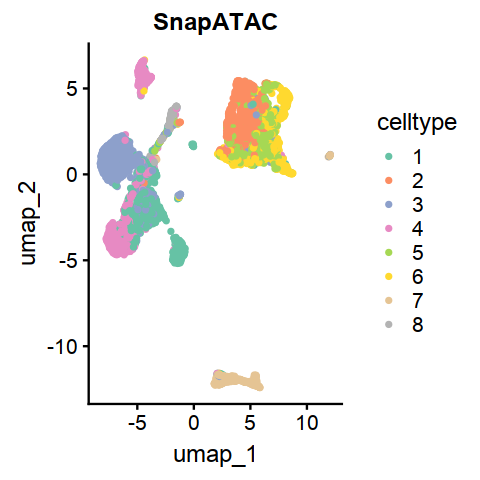

In [11]:
p_SnapATAC <- plot_umap(df_umap_SnapATAC,labels = labels,colormap = colormap,title='SnapATAC')
p_SnapATAC

### SCRAT

In [12]:
df_umap_SCRAT <- run_umap(fm_SCRAT)

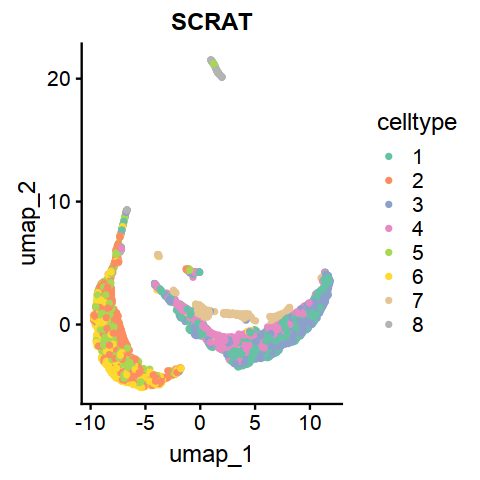

In [13]:
p_SCRAT <- plot_umap(df_umap_SCRAT,labels = labels,colormap = colormap,title='SCRAT')
p_SCRAT

#### Save feature matrices and UMAP coordinates

In [14]:
dataset = '10xpbmc_no_blacklist_filtering'

In [15]:
saveRDS(df_umap_SnapATAC,paste0(path_umap,'df_umap_SnapATAC.rds'))
saveRDS(df_umap_SCRAT,paste0(path_umap,'df_umap_SCRAT.rds'))

In [16]:
save.image(file = 'run_umap_10xpbmc5k_no_blacklist_filtering.RData')

In [17]:
fig_width = 8
fig_height = 4

options(repr.plot.width=fig_width, repr.plot.height=fig_height)
combined_fig = cowplot::plot_grid(p_SnapATAC+theme(legend.position = "none"),
                   p_SCRAT+theme(legend.position = "none"),
                   labels = "",nrow = 1)

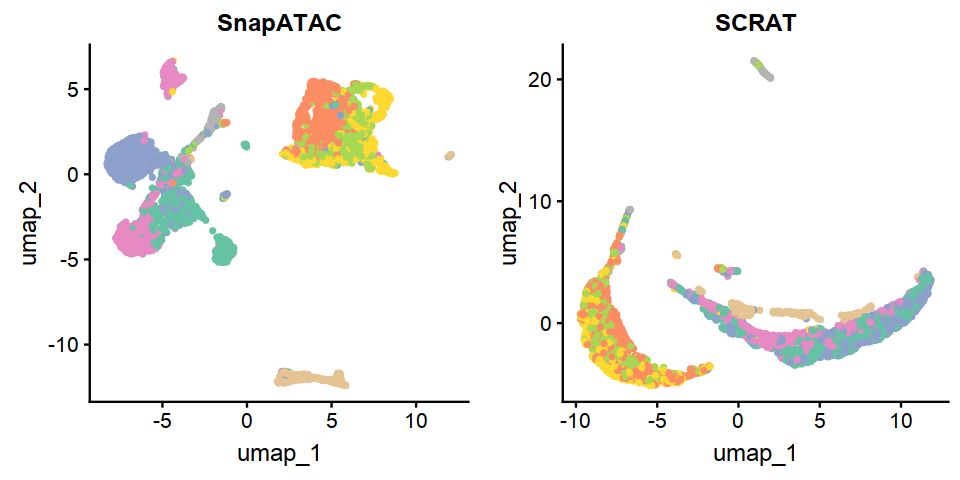

In [18]:
combined_fig

In [20]:
cowplot::ggsave(combined_fig,filename = "10x_pbmc_5k_no_blacklist_filtering.pdf", width = fig_width, height = fig_height)